<a href="https://colab.research.google.com/github/Leos1999/MarketTrendAnalyser/blob/master/Stock_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "leosabraham" # username from the json file
os.environ['KAGGLE_KEY'] = "9e8785651868d3ca4384269a20773ea2" # key from the json file
!kaggle datasets download -d leosabraham/stock-intern
!unzip /content/stock-intern.zip

 29% 9.00M/30.7M [00:00<00:01, 16.2MB/s]
100% 30.7M/30.7M [00:00<00:00, 42.0MB/s]
Archive:  /content/stock-intern.zip
  inflating: fundamentals.csv        
  inflating: prices-split-adjusted.csv  
  inflating: prices.csv              
  inflating: securities.csv          


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

In [ ]:
prices = pd.read_csv("/content/prices-split-adjusted.csv")

In [ ]:
data = prices.loc[prices['symbol']=='CAT']
# data = data.drop('date',axis=1)
# data = data.drop('symbol',axis=1)

In [ ]:
data.head()

,date,symbol,open,close,low,high,volume
323,2010-01-04,CAT,57.650002,58.549999,57.509998,59.189999,7325600.0
790,2010-01-05,CAT,58.549999,59.250000,58.230000,59.439999,5697200.0
1258,2010-01-06,CAT,59.180000,59.430000,59.049999,59.930000,4718800.0
1726,2010-01-07,CAT,59.299999,59.669998,58.650002,59.900002,5432900.0
2194,2010-01-08,CAT,59.250000,60.340000,59.250000,60.369999,6651300.0


In [ ]:
data = data.iloc[:,3].values.reshape(-1,1)
data.shape
scaler = MinMaxScaler(feature_range = (0, 1))

In [ ]:
def train_test_split_norm(data):
  data_norm = scaler.fit_transform(data)

  size = 0.85
  train_size = int(len(data_norm) * size)
  test_size = len(data_norm) - train_size
  train, test = data_norm[0:train_size, :], data_norm[train_size:len(data_norm), :]
  # print("Number of entries (training set, test set): " + str((len(train), len(test))))
  return train,test

In [ ]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [ ]:
def window_maker(data,window_size):
  train,test = train_test_split_norm(data)
  train_X, train_Y = create_dataset(train, window_size)
  test_X, test_Y = create_dataset(test, window_size)
  # print("Original training data shape:")
  # print(train_X.shape)
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  # print("New training data shape:")
  # print(train_X.shape)
  return train_X,train_Y,test_X,test_Y,train,test

In [ ]:
def model_bulid(train_X,train_Y,test_X,test_Y,window_size,n1,n2):
  model = Sequential()
  model.add(LSTM(n1,input_shape = (1, window_size),return_sequences=True))
  model.add(LSTM(n2,input_shape = (1, window_size)))
  model.add(Dense(1))
  model.compile(loss = "mean_squared_error", optimizer = "adam",metrics='mean_absolute_error')
  history = model.fit(train_X, train_Y, epochs = 20, batch_size = 1, verbose = 0,validation_data=(test_X,test_Y))
  # plt.plot(history.history['loss'], label='train')
  # plt.plot(history.history['val_loss'], label='test') 
  # plt.legend()
  # plt.show()
  return history,model

In [ ]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [ ]:
def predict_and_score(X, Y):   
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

**12**,18
100,48
84,10
80,38 - 
70,15 - 51
30,25 - 51.39
30,5 - 51.39
15,30 - 51.79
5 10

In [ ]:
best_win = 0
n1=0
n2=0
for k in reversed(range(5,85,5)):
  for j in reversed(range(5,45,5)):
    train_X,train_Y,test_X,test_Y,train,test = window_maker(data,12)
    history,model = model_bulid(train_X,train_Y,test_X,test_Y,12,15,30)

    rmse_train, train_predict = predict_and_score(train_X, train_Y)
    rmse_test, test_predict = predict_and_score(test_X, test_Y)

    #print("Training data score:",rmse_train,"RMSE for lstm size ",k)
    #print("Test data score:",rmse_test,"RMSE for lstm size ",k)
    pred = scaler.inverse_transform(model.predict(test_X))
    org = scaler.inverse_transform(test)
    org = org[12+1:]
    win = 0
    loss = 0
    for i in range(1,len(pred)):
      if pred[i] > pred[i-1] and org[i] > org[i-1]:
        win += 1
      elif pred[i] < pred[i-1] and org[i] < org[i-1]:
        win += 1
      else:
        loss+=1
    # print(f'\r{k,j} iter', end='', flush=True)
    prob = ((win/(win+loss))*100)
    if prob > best_win:
        model.save("stock_w2_l2.hdf5")
        best_win = prob
        print("Saved current model....")
        n1 = k
        n2 = j
    if prob > 50:
      print("Overall win probablity:",round(prob,2)," for",k,j)
      print("Test data score:",rmse_test,"RMSE for lstm size ",k)
      print("\n")
    #print("Overall win probablity:",round(prob,2),)  
    #print("Overall loss probablity:",((loss/(win+loss))*100))
print(best_win,n1,n2)

Saved current model....
Overall win probablity: 51.0
50.99601593625498 0 0


In [ ]:
# train_predict_plot = np.zeros(data_norm.shape)
# train_predict_plot[:, :] = np.nan
# train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# test_predict_plot = np.zeros(data_norm.shape)
# test_predict_plot[:, :] = np.nan
# test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(data) - 1, :] = test_predict

# plt.figure(figsize = (15, 5))
# plt.plot(scaler.inverse_transform(data_norm), label = "True value")
# plt.plot(train_predict_plot, label = "Training set prediction")
# plt.plot(test_predict_plot, label = "Test set prediction")
# plt.xlabel("Months")
# plt.ylabel("Passengers")
# plt.title("Comparison true vs. predicted training / test")
# plt.legend()
# plt.show()

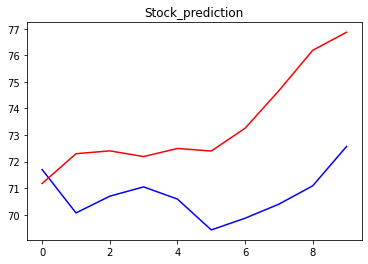

In [ ]:
model = load_model("/content/stock_w2_l2.hdf5")
pred = model.predict(test_X)
pred = scaler.inverse_transform(pred[100:110])
tst = test[3:]
plt.plot(scaler.inverse_transform(tst[100:110]),color='blue')
plt.plot(pred,color='red')
plt.title('Stock_prediction')
plt.show()

In [ ]:
pred = scaler.inverse_transform(model.predict(test_X))
org = scaler.inverse_transform(test)
org = org[13:]
win = 0
loss = 0
for i in range(1,len(org)):
  if pred[i] > pred[i-1] and org[i] > org[i-1]:
    win += 1
  elif pred[i] < pred[i-1] and org[i] < org[i-1]:
    win += 1
  else:
    loss+=1
print(win,loss)
print("Overall win probablity:",((win/(win+loss))*100))
print("Overall loss probablity:",((loss/(win+loss))*100))

128 123
Overall win probablity: 50.99601593625498
Overall loss probablity: 49.00398406374502


In [ ]:
p = scaler.inverse_transform(model.predict(train_X))

In [ ]:
p[0]

array([60.31873], dtype=float32)

In [ ]:
org = scaler.inverse_transform(train)

In [ ]:
train.shape

(1497, 1)

In [ ]:
train_X.shape

(1493, 1, 3)

In [ ]:
org[0:5]

array([[58.549999],
       [59.25    ],
       [59.43    ],
       [59.669998],
       [60.34    ]])